In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import folium
from shapely.geometry import Point
import chardet

from mvprofessor.config import raw_data_dir, int_data_dir
from mvprofessor.custom_funcs import get_endpoints, make_blobs

phrs = pd.read_pickle(int_data_dir/'Prof_ICA_data.pkl')

The goal is to find nodes that are represented in both the ICA hourly data and the derived topology, then determine which of these nodes may benefit from voltage regulation hardware.

In [2]:
# Compare node ids between ICA hourly data and the topology graph
# To-do: enodes containing multiple endpoints should be averaged/aggregated 
gdf = pd.read_pickle(int_data_dir/'professor.pkl')

gdf_nodes = np.unique(gdf['node_id'])
phrs_nodes = np.unique(phrs['Node_ID'])

# Intersection of the two lists
hasICA = list(set(gdf_nodes) & set(phrs_nodes))

gdf['hasICA'] = 0
gdf.loc[gdf['node_id'].isin(hasICA),'hasICA']=1

In [3]:
# Find and flag nodes that are many voltage regulation candidates
# i.e., nodes where Voltage Fluctuation min is the contraint at ANY hour
Load_Prof_Type = 'MIN'
phrs_min = phrs[phrs['Load_Profile_Type']=='MIN']
phrs_vr = phrs_min[phrs_min['Voltage_Fluctuation_(kW)'] < phrs_min['Thermal_(kW)']]

vr_nodes = np.unique(phrs_vr['Node_ID'])

vr_hasICA = list(set(hasICA) & set(vr_nodes))
gdf['vr'] = 0
gdf.loc[gdf['node_id'].isin(vr_hasICA),'vr']=1

In [4]:
# Plot the nodes with/without ICA data, 
# as well as nodes potential benefitting from voltage regulation
lgd_txt = '<span style="color: {col};">{txt}</span>'

m=gdf[(gdf['hasICA']==1)].explore(color='blue',
    name=lgd_txt.format(txt="DRPEP Line Sections with ICA data",col='blue'))

gdf[gdf['hasICA']==0].explore(m=m,color='red',style_kwds=dict(weight=5),
    name=lgd_txt.format(txt="DRPEP Line Sections lacking ICA data",col='red'))

gdf[gdf['vr']==1].explore(m=m,color='orange',style_kwds=dict(weight=5),
    name=lgd_txt.format(txt="Potential Voltage Reg. Segments",col='orange'))

folium.LayerControl().add_to(m)
display(m)


In [5]:
# Save in active folder for full-screen viewing (or viewing from Explorer)
folium.LayerControl().add_to(m)
m.save('nodes_ICA_data.html')

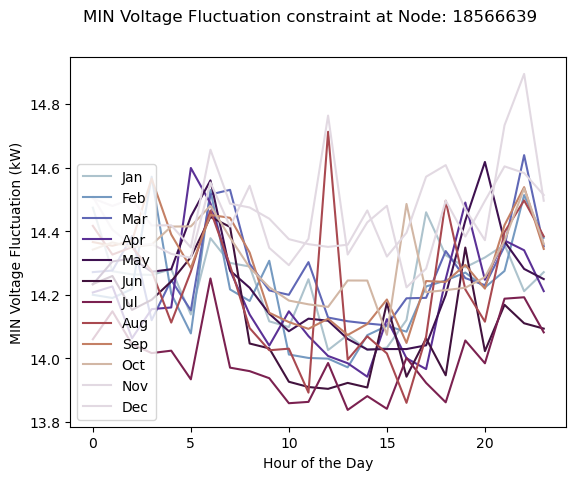

In [6]:
# Plot the 12 months for a given node
# sample 12 colors from 'twilight', a diverging colormap.
# The idea is to highlight the summer months, when we expect max constraint
twil = cm.get_cmap('twilight', 12)


node = vr_nodes[1] # pick a random node from VR candidates
months = np.arange(1,13,1)
month_str = ['Jan','Feb','Mar','Apr','May','Jun',
             'Jul','Aug','Sep','Oct','Nov','Dec']

field = 'Voltage_Fluctuation_(kW)'
mm = 'MIN' # min or max

fig, ax = plt.subplots()
for m in months:
    z = phrs.loc[(phrs['Node_ID']==node)
                    & (phrs['Month']==m)
                    & (phrs['Load_Profile_Type']==mm),['Hour',field]]
    z=z.sort_values('Hour',axis=0)
    ax.plot(z['Hour'],z[field]/1000,color=twil(m))

# Plot formatting
title_txt = '{} {} constraint at Node: {}'.format(mm, field, node).replace('_',' ')
title_txt = title_txt.replace(' (kW)','')
fig.suptitle(title_txt)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('{} {}'.format(mm,field).replace('_',' '))    
ax.legend(month_str,loc='lower left')
plt.show()